這邊參考的主要來源是[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/windy_grid_world.py)

Example 6.5: Windy Gridworld
![](https://i.imgur.com/MTwwarC.png)

如上圖的小插圖所示，那是一個標準的gridworld，有開始(S)與目標(G)狀態，有一點不同：有一個側風在中間由下往上吹。那actions一樣是標準的那四個，上、下、右、左，但是到中間之後你的next state會被風往上吹而導致偏移，造成偏移的強度會依不同的column而有所不同。風吹的強度也在每個column上給出，一看你就知道會被吹幾格。舉例來說，如果你在目標(G)右邊的格子，然後你執行action是向左，那你就會被帶到目標(G)的上面一格。這是undiscounted episodic task，在你到達目標之前，你每次都會得到reward=-1。

那個趨勢線則是你用$\epsilon-$greedy Sarsa來處理這個任務的結果，其$\epsilon=0.1, \alpha=0.5$，然後所有的$s, a$的初始$Q(s,a)=0$。上圖可以看的到，斜率增加說明的是，隨著時間的推移，我們可以更快的到達目標(G)。在經過8000個time steps之後，greedy policy早就是optimal(插圖說明的就是它的trajectory)；一直是$\epsilon-$greedy exploration的話，大概每個episodes都是平均17個steps可以完成，比最小15個steps還要多2個steps。注意到，這個任務用MC可能不是那麼輕鬆，因為不是所有的policies都能夠保證終止。如果曾經有policy被發現會導致agent停留在同一個state，那下一個episode它就永遠不會終止。像是Sarsa這種online learning methods不會有這樣的問題，因為它們會很快的在episode的期間學習，如果policies不夠好，那就換一個。

$(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$，每個元素的第一個字拿出來，就是Sarsa，下面給出公式6.7做為參考：
$$Q(S_t,A_t)\leftarrow Q(S_t,A_t) + \alpha[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)] \tag{6.7}$$

![](https://i.imgur.com/cpcvCNi.png)

首先載入需求套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt

首先定義環境參數

In [2]:
WORLD_HEIGHT = 7
WORLD_WIDTH = 10

定義風速在每個column的影響

In [3]:
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

定義ACTION

In [4]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTIONS

[0, 1, 2, 3]

定義$\epsilon$，這代表著你的agent去探索其它非最佳的action的機率

In [5]:
EPSILON = 0.1

定義step size，$\alpha$

In [6]:
ALPHA = 0.5

定義REWARD，根據範例說明，每個time step都會-1

In [7]:
REWARD = -1

定義起始位置、結束位置

In [8]:
START_STATE = [3, 0]
GOAL_STATE = [3, 7]

設置一個函數來定義每一個time step選擇action的結果

In [9]:
def step(state, action):
    """每個time step的結果    
    state: 當下的state
    action: 選擇的action
    
    每次的移動都要考慮進去風對於移動的影響，
    因此會做一個判斷，避免出界
    
    return:
        next state
    """
    i, j = state
    if action == ACTION_UP:
        # 往上，column不動，row要注意出界        
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        # 往下，column不動，row要注意出界
        # 取min是因為避免出下界
        # 取max是怕風大太強吹出上界
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        # 往左，要考慮到風吹的影響，也要注意出界
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    

In [10]:
state = START_STATE
action = ACTION_UP
next_state = step(state, action)
state, next_state

([3, 0], [2, 0])

設置一個函數來執行episode

In [11]:
def episode(q_values):
    time = 0
    # 設置初始狀態
    state = START_STATE
    # 決定action
    # 如果根據EPSILON的機率來抽真的抽到1，那就是探索，隨機從中選擇一個action
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        # 如果是greedy，那就從q_value裡面找一個最大的
        # 如果有很多個最大值，那就隨便來一個吧
        # 先取得該state的value，會分別記錄上、下、左、右的value
        _values = q_values[state[0], state[1], :]
        # 從中取最大值，np.random.choice的目的在於，如果有多個最大值就隨機取
        # 下面的List comprehension說的是，對_values做for loop
        # 然後如果_value是_values中最大的那個值，那就記錄_action
        action = np.random.choice([_action for _action, _value in enumerate(_values) if _value == np.max(_values)])
    
    # 開始跑至GOAL STATE
    while state != GOAL_STATE:
        next_state = step(state, action)
        # 利用next state來決定next action
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            _values = q_values[next_state[0], next_state[1], :]        
            next_action = np.random.choice([_action for _action, _value in enumerate(_values) if _value == np.max(_values)])

        # 每過一個time step就做一次的SARSA update
        # 因為是undiscount，因此就沒有特別計算discount
        q_values[state[0], state[1], action] += \
            ALPHA * (REWARD + 
                         q_values[next_state[0], next_state[1], next_action] - 
                             q_values[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    
    return time

In [12]:
q_value = np.random.randint(1, 10, (WORLD_HEIGHT, WORLD_WIDTH, 4))

In [13]:
_values = q_value[state[0], state[1], :]
_values

array([6, 5, 1, 6])

In [14]:
[_action for _action, _value in enumerate(_values) if _value == np.max(_values)]

[0, 3]

下面等價於上面的list comprehension

In [15]:
for a, v in enumerate(_values):
    if v == np.max(_values):
        print(a, v)

0 6
3 6


下面我們設置一個函數來執行

In [16]:
def run(episodes):
    # 那個4就是4個action
    q_values = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    # 記錄每個episode執行幾個time step
    steps = []    
    
    # 跑500次
    for i in range(episodes):
        steps.append(episode(q_values))
        
    # 計算累加
    steps = np.add.accumulate(steps)
    
    plt.plot(steps, np.arange(1, len(steps) + 1))
    plt.xlabel('Time Steps')
    plt.ylabel('Episodes')
    
    plt.show()
    # 這樣寫應該不是很好，又是show圖又是回傳的
    # 不過就只是為了方便
    return q_values
    

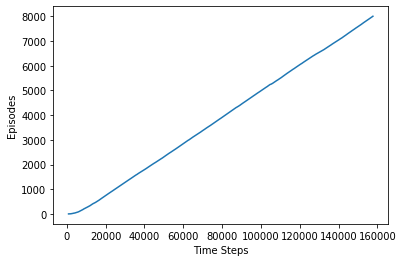

In [17]:
q_values = run(8000)

有了q values就可以決定control，做法很簡單，greedy

In [18]:
optimal_policy = []
for i in range(0, WORLD_HEIGHT):
    optimal_policy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == GOAL_STATE:
            optimal_policy[-1].append('G')
            continue
        bestAction = np.argmax(q_values[i, j, :])
        if bestAction == ACTION_UP:
            optimal_policy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimal_policy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimal_policy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimal_policy[-1].append('R')
print('Optimal policy:')
for row in optimal_policy:
    print(row)
print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))

Optimal policy is:
['D', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'U']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']
